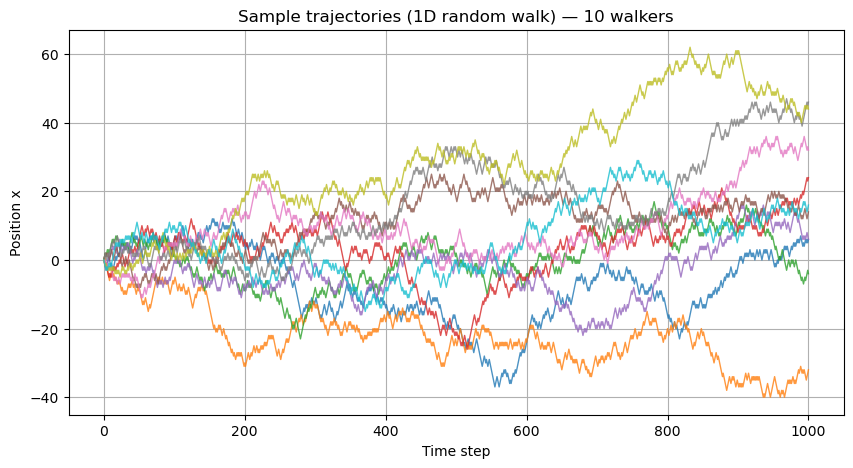

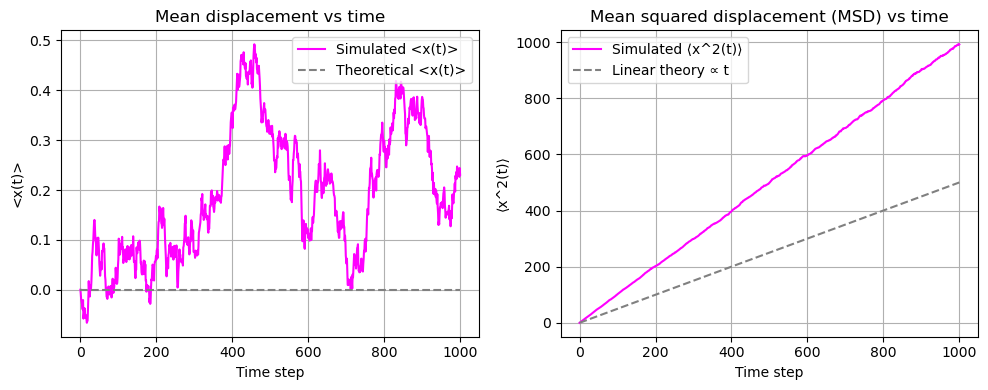

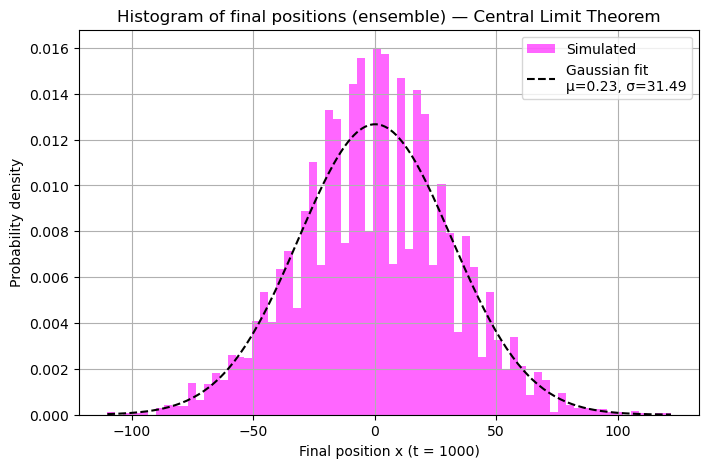

MSD ~ 0.9932 * t + 1.9045   (slope ≈ step_size^2 for unbiased walk)


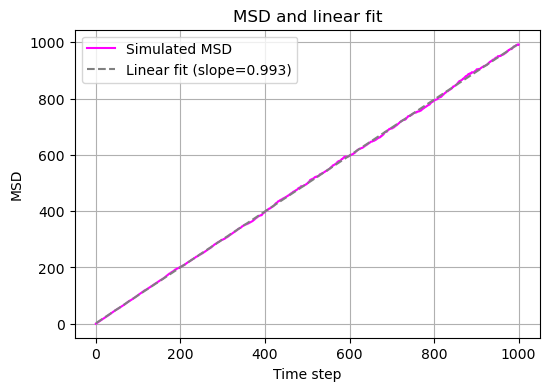

In [1]:
# 1D Drunkard's Walk — ensemble simulation and analysis
# Copy into a Jupyter notebook cell and run.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------
# Parameters
# ----------------------------
N_walkers = 5000     # number of independent walkers (ensemble size)
N_steps = 1000       # number of time steps
p_right = 0.5        # probability to step right (if 0.5 -> unbiased)
step_size = 1.0      # step length per step (+/- step_size)
seed = 42

np.random.seed(seed)

# ----------------------------
# Generate steps: shape (N_walkers, N_steps)
# each step is +1 or -1 times step_size
# ----------------------------
r = np.random.rand(N_walkers, N_steps)
steps = np.where(r < p_right, 1.0, -1.0) * step_size

# ----------------------------
# Trajectories: cumulative sum over time axis
# positions shape: (N_walkers, N_steps+1) including t=0
# ----------------------------
positions = np.concatenate((np.zeros((N_walkers,1)), np.cumsum(steps, axis=1)), axis=1)  # include x(0)=0
time = np.arange(N_steps+1)

# ----------------------------
# Sample trajectories plot (a few walkers)
# ----------------------------
n_plot = 10  # number of sample trajectories to show
plt.figure(figsize=(10,5))
for i in range(n_plot):
    plt.plot(time, positions[i], alpha=0.8, lw=1)
plt.xlabel('Time step')
plt.ylabel('Position x')
plt.title(f'Sample trajectories (1D random walk) — {n_plot} walkers')
plt.grid(True)
plt.show()

# ----------------------------
# Ensemble statistics: mean and MSD
# ----------------------------
mean_x = positions.mean(axis=0)             # <x(t)>
msd = (positions**2).mean(axis=0)           # <x^2(t)>

# Theoretical expectations for unbiased walk:
# <x(t)>_theory = (2p-1) * step_size * t
# MSD_theory (for unbiased p=0.5) = step_size^2 * t
drift = (2*p_right - 1) * step_size
theory_mean = drift * time
theory_msd = ( (2*p_right*(1-p_right) + (2*p_right-1)**2 ) * step_size**2 ) * time
# Note: above general formula gives Var(x) = 4 p (1-p) step_size^2 * t? 
# Simpler: for unbiased p=0.5: Var = step_size^2 * t, MSD = Var + mean^2 -> matches.

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time, mean_x, label='Simulated <x(t)>', color='magenta')
plt.plot(time, theory_mean, '--', label='Theoretical <x(t)>', color='grey')
plt.xlabel('Time step')
plt.ylabel('<x(t)>')
plt.title('Mean displacement vs time')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time, msd, label='Simulated ⟨x^2(t)⟩', color='magenta')
plt.plot(time, theory_msd, '--', label='Linear theory ∝ t', color='grey')
plt.xlabel('Time step')
plt.ylabel('⟨x^2(t)⟩')
plt.title('Mean squared displacement (MSD) vs time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Histogram of final positions and Gaussian fit
# ----------------------------
final_positions = positions[:, -1]
mu_sim = final_positions.mean()
sigma_sim = final_positions.std(ddof=0)

plt.figure(figsize=(8,5))
n_bins = int(np.sqrt(N_walkers))
counts, bins, patches = plt.hist(final_positions, bins=n_bins, density=True, alpha=0.6, color='magenta', label='Simulated')
# Gaussian fit
x_vals = np.linspace(bins[0], bins[-1], 200)
plt.plot(x_vals, norm.pdf(x_vals, loc=mu_sim, scale=sigma_sim), 'k--', label=f'Gaussian fit\nμ={mu_sim:.2f}, σ={sigma_sim:.2f}')
plt.xlabel('Final position x (t = {})'.format(N_steps))
plt.ylabel('Probability density')
plt.title('Histogram of final positions (ensemble) — Central Limit Theorem')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Optional: show how variance grows linearly
# Fit MSD ~ a * t + b
# ----------------------------
coeffs = np.polyfit(time[1:], msd[1:], 1)  # exclude t=0
slope, intercept = coeffs
print(f"MSD ~ {slope:.4f} * t + {intercept:.4f}   (slope ≈ step_size^2 for unbiased walk)")

plt.figure(figsize=(6,4))
plt.plot(time, msd, label='Simulated MSD', color='magenta')
plt.plot(time, slope*time + intercept, '--', label=f'Linear fit (slope={slope:.3f})', color='grey')
plt.xlabel('Time step')
plt.ylabel('MSD')
plt.title('MSD and linear fit')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Optional animation: animate one walker
# (Works in Jupyter; comment out if slow)
# ----------------------------
do_animation = True   # set True to see animation
if do_animation:
    walker_id = 0
    pos = positions[walker_id]

    fig, ax = plt.subplots(figsize=(10,2))
    ax.set_xlim(positions.min()-5, positions.max()+5)
    ax.set_ylim(-1, 1)
    point, = ax.plot([], [], 'o', color='magenta')
    trail, = ax.plot([], [], '-', color='magenta', alpha=0.4)
    ax.set_yticks([])
    ax.set_xlabel('x')

    def init_anim():
        point.set_data([], [])
        trail.set_data([], [])
        return point, trail

    def update_anim(i):
        point.set_data([pos[i]], [0])
        trail.set_data(pos[:i+1], np.zeros(i+1))
        return point, trail

    ani = FuncAnimation(fig, update_anim, frames=len(pos), init_func=init_anim, interval=10, blit=True)
    display(HTML(ani.to_jshtml()))
